In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal
import matplotlib.pylab as pl
import matplotlib as mpl
from matplotlib import cm
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
mpl.rcParams['figure.dpi']=300

plt.rcParams.update({
    "text.usetex": True,
    "font.size" : 16,
    "font.family": "serif",
    "font.serif": 'cm10',
    'savefig.bbox' : 'tight'})

from tqdm import tqdm
from utils.ASA import get_params,ASA_propagator,ASA_sources,ASA_focused_sources
from utils.FFT import custom_fft2,custom_ifft2



/var/folders/cw/5xff940s6559c90nyhzx9s9m0000gn/T/ipykernel_54160/2671215102.py:8: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']


In [3]:
# We get the parameters
config = get_params()
# We define the aperture radius
radius = 15*config['lambda']

In [4]:
def ASA_focused_sources(config, type,r, focusing_distance):

    source = ASA_sources(config, type, r)

    delay = np.zeros((config['Nx'], config['Ny']), dtype='complex')

    for i in range(config['Nx']) : 
        for j in range(config['Ny']) : 
            
            delta_wave_length = np.sqrt(config['ax'][i]**2+config['ay'][j]**2+focusing_distance**2)-focusing_distance
            f=delta_wave_length/config['lambda']-np.floor(delta_wave_length/config['lambda'])
            #print(np.exp(-1j*2*np.pi*f))
            delay[i,j] = np.exp(-1j*2*np.pi*f)
            
    return delay*source



In [5]:
# Minimum and maximum z values
z_min = 0 #m
z_max = 0.2 #m
# Number of points for the z-axis
Nz = 4000
# Sampling period 
depth_sampling_period = (z_max-z_min)/Nz

# We define the hanning window (as defined in MATLAB)

hanning_window = np.array([[0.25,0.5,0.25],[0.5,1,0.5],[0.25,0.5,0.25]])
hanning_window = hanning_window/np.sum(hanning_window)

# Source wave field
U_0_mod_delayed = scipy.signal.convolve2d(ASA_focused_sources(config, type='square',r=radius, focusing_distance=0.06),hanning_window,'same')

# Depth vector Z
Z = np.arange(z_min,z_max,depth_sampling_period)

In [6]:
# This cell may take few moments to be processed !

# Wave field matrix W (each column <-> wavefield for all x, at y=0 cm and z)

W = np.zeros((config['Nx'],len(Z)),dtype='complex')

for i in tqdm(range(len(Z))) :
    
    # We compute the propagation matrix
    prop = ASA_propagator(config=config,z=Z[i])
    # We propagate the wave field
    U = custom_ifft2(custom_fft2(U_0_mod_delayed)*prop)
    W[:,i] = U[:,config['Ny']//2]

  0%|                                                  | 0/4000 [00:00<?, ?it/s]/Users/thomasaussagues/SynologyDrive/Drive/UiO/Signal Array Processing/Exercices/Mandatory1/Jupyter/utils/ASA.py:46: RuntimeWarning: invalid value encountered in sqrt
  prop = np.exp(1j * 2 * np.pi * z * np.sqrt(1 - uSq - vSq) / config['lambda'])
100%|███████████████████████████████████████| 4000/4000 [05:53<00:00, 11.32it/s]


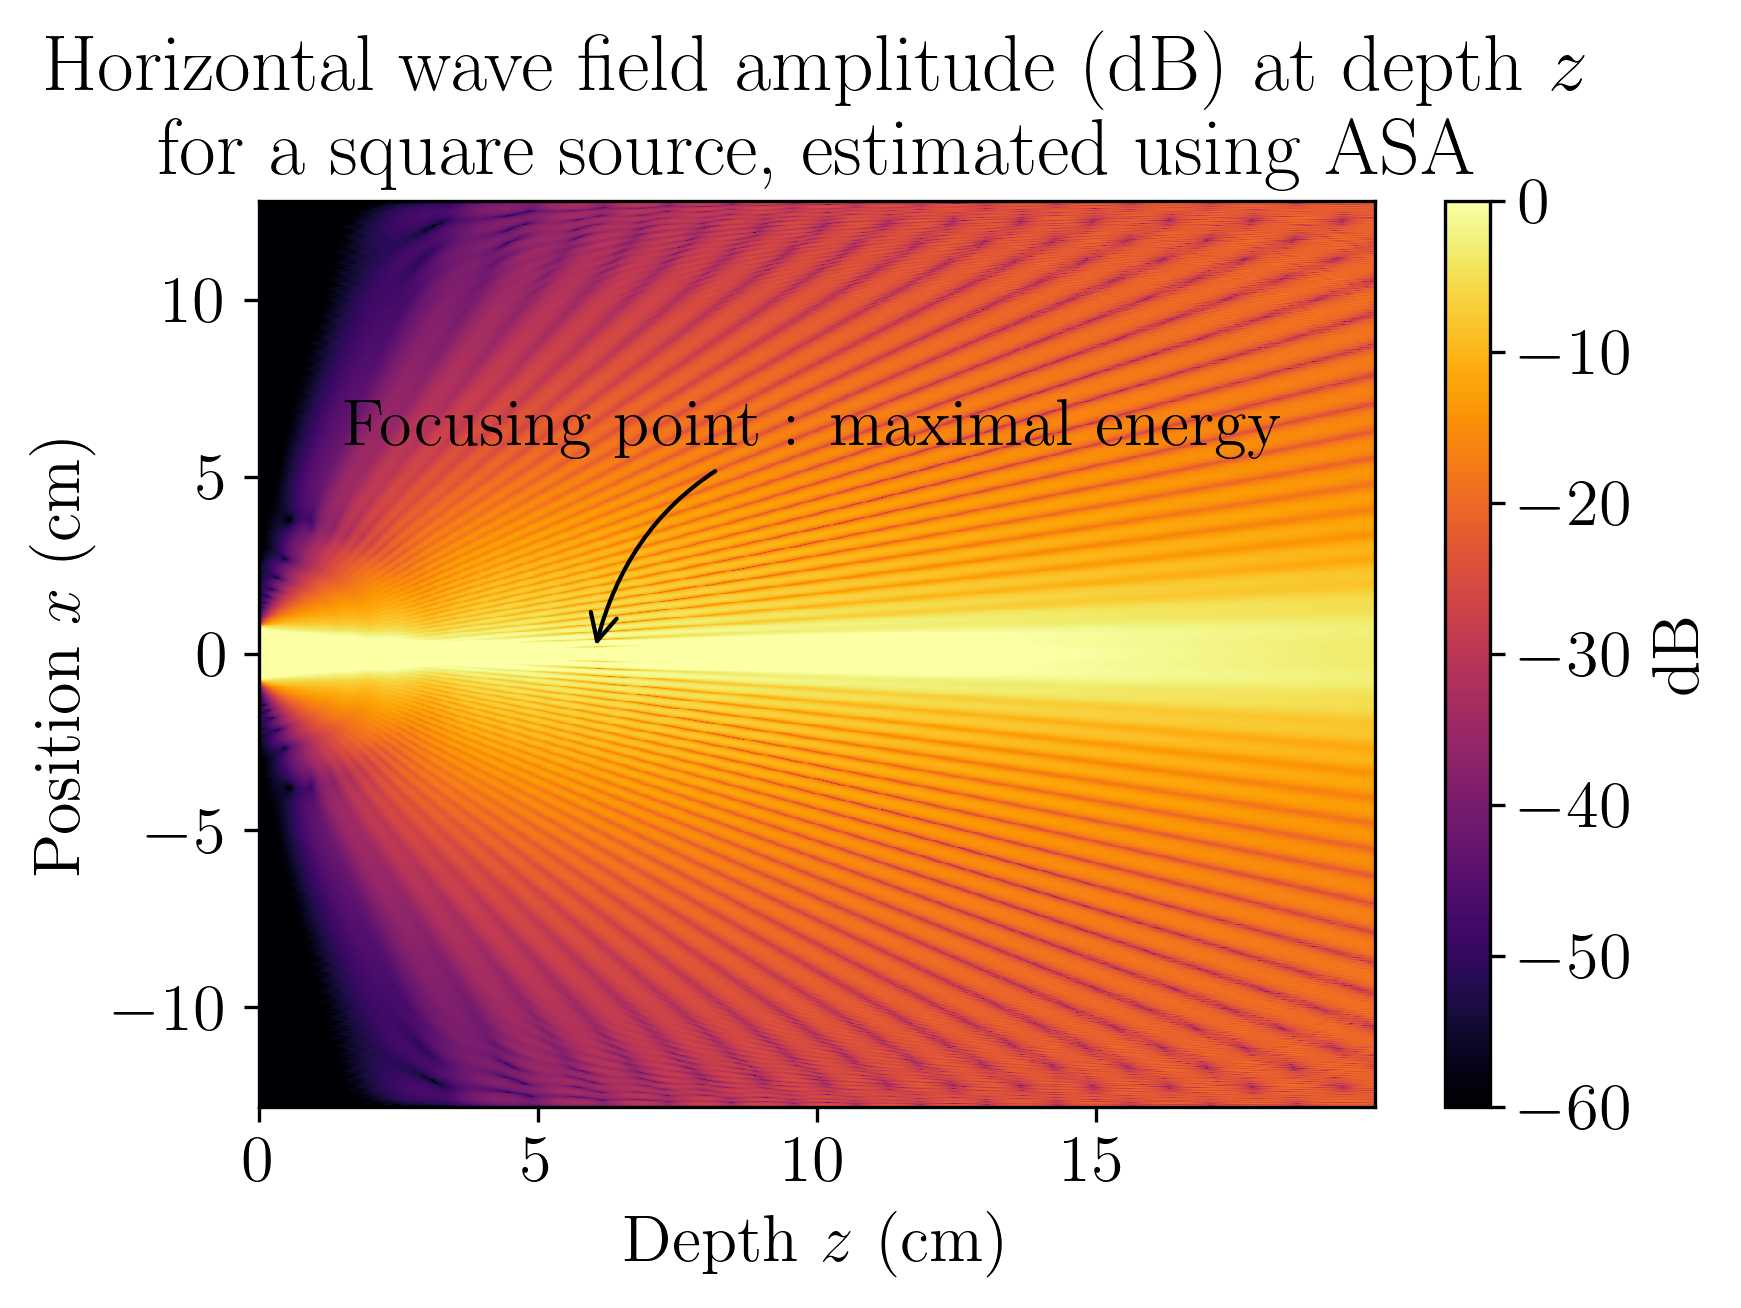

In [12]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams.update({'font.size': 16})


# 2D image of the predicted wavefield for y=0m

plt.pcolormesh(Z*1e2,config['ax']*1e2,10*np.log10(np.abs(W)),cmap='inferno',shading='auto')
#plt.clim(np.min(10*np.log10(np.abs(W[-1,:])))+40,np.max(np.log10(np.abs(W[-1,:]))))
#plt.ylim([-1,1])
near_field_limit = (2*radius)**2/(4*config['lambda'])
far_field_limit = (2*radius)**2/config['lambda']

#plt.plot([near_field_limit,near_field_limit],[np.min(config['ax'])*1e2,np.max(config['ax'])*1e2],linestyle='--',color='k')
#plt.plot([far_field_limit,far_field_limit],[np.min(config['ax'])*1e2,np.max(config['ax'])*1e2],linestyle='--',color='k')
plt.ylabel('Position $x$ (cm)')
plt.xlabel('Depth $z$ (cm)')
plt.title('Horizontal wave field amplitude (dB) at depth $z$\n for a square source, estimated using ASA')
c = plt.colorbar()
c.set_label('dB')
plt.clim(-60,0)

plt.annotate('Focusing point : maximal energy',
         xy=(6, 0), xycoords='data',
         xytext=(-60, +50), textcoords='offset points', fontsize=16,
         arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=+.3"))


plt.savefig('images/ASA/square/wave_field_2D_xz_square_smoothed_focused.png',dpi=300)

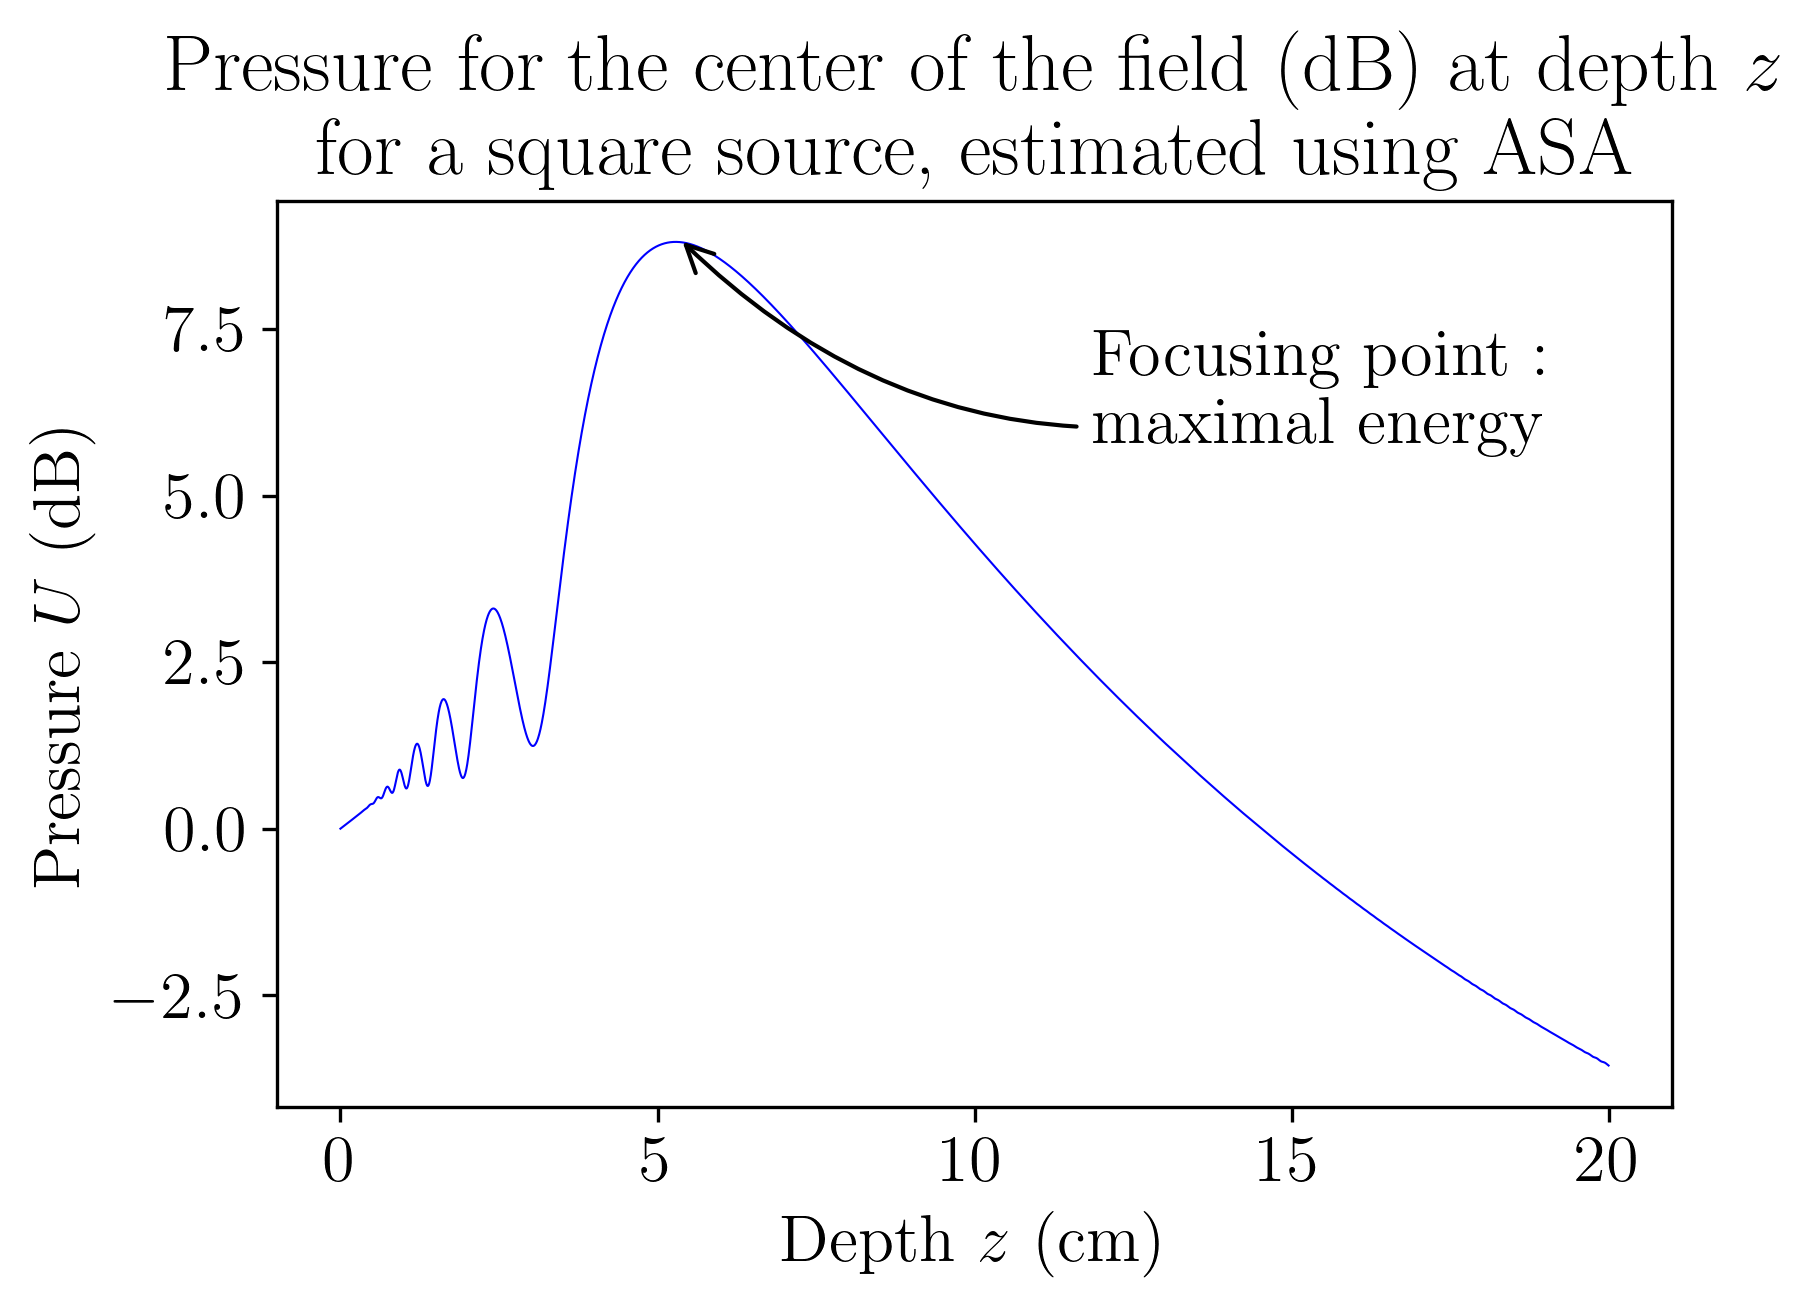

In [8]:
# Plot the pressure for the center of the field for all ranges (i.e. a 1S plot, along the z-axis,
# and starting in origo).

plt.plot(Z*1e2,20*np.log10(np.abs(W[config['Nx']//2,:])),color='blue',linewidth=0.5)
plt.xlabel('Depth $z$ (cm)')
plt.ylabel('Pressure $U$ (dB)')
plt.title('Pressure for the center of the field (dB) at depth $z$ \n for a square source, estimated using ASA')
plt.annotate('Focusing point :\n maximal energy',
         xy=(5.3, 8.9), xycoords='data',
         xytext=(100, -50), textcoords='offset points', fontsize=16,
         arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-.3"))




plt.savefig('images/ASA/square/wave_field_1D_center_square_smoothed_focused.png',dpi=300)

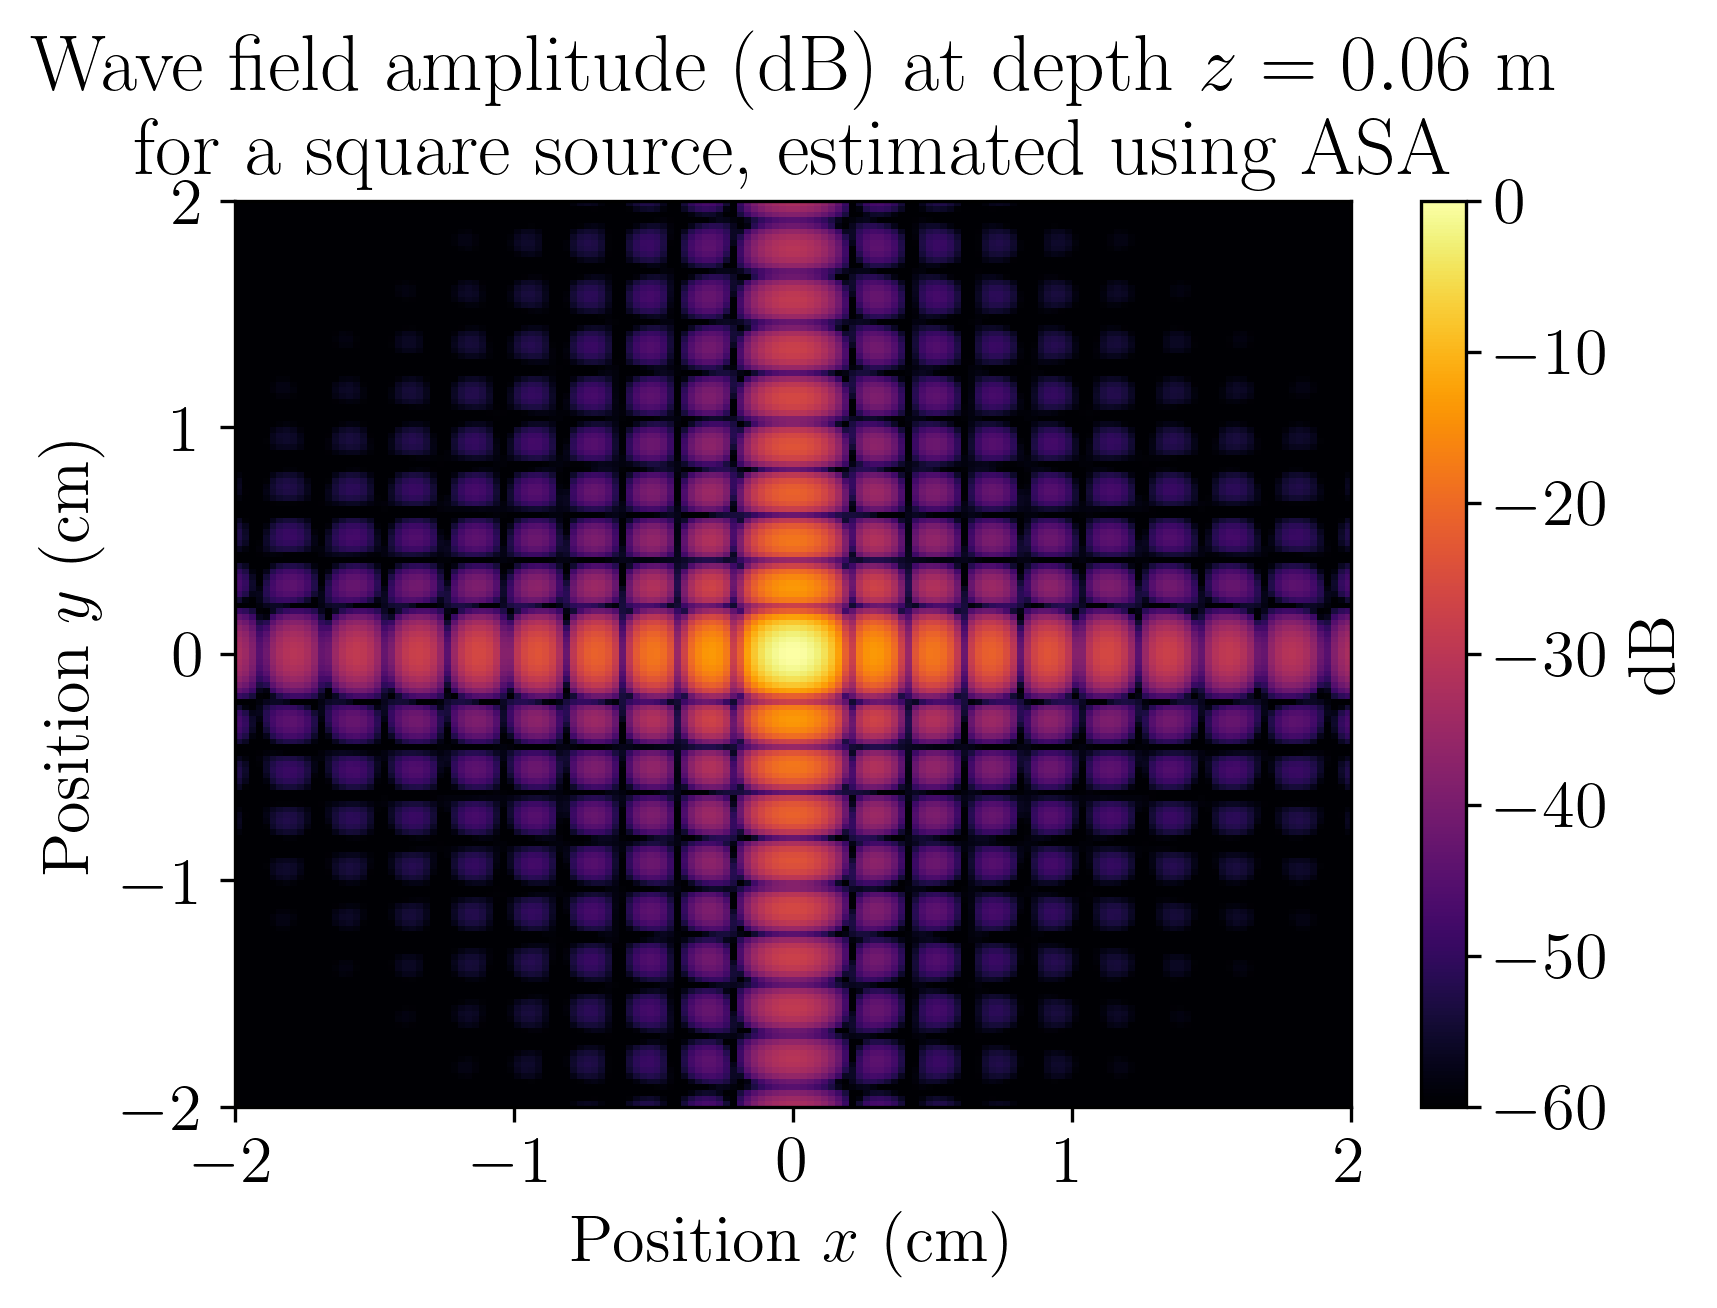

In [14]:
config = get_params()
radius = 15*config['lambda']
prop = ASA_propagator(config=config,z=0.06)


U_mod_delayed = custom_ifft2(custom_fft2(U_0_mod_delayed)*prop)



plt.pcolormesh(config['ax']*1e2,config['ay']*1e2,20*np.log10(np.abs(U_mod_delayed)/np.max(np.abs(U_mod_delayed))),cmap='inferno',shading='auto')
plt.clim(-60,0)
plt.xlabel('Position $x$ (cm)')
plt.ylabel('Position $y$ (cm)')
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.title('Wave field amplitude (dB) at depth $z=0.06$ m \n for a square source, estimated using ASA')
c = plt.colorbar()
c.set_label('dB')
plt.savefig('images/ASA/square/wave_field_2D_z=8cm_square_smoothed_focused.png',dpi=300)



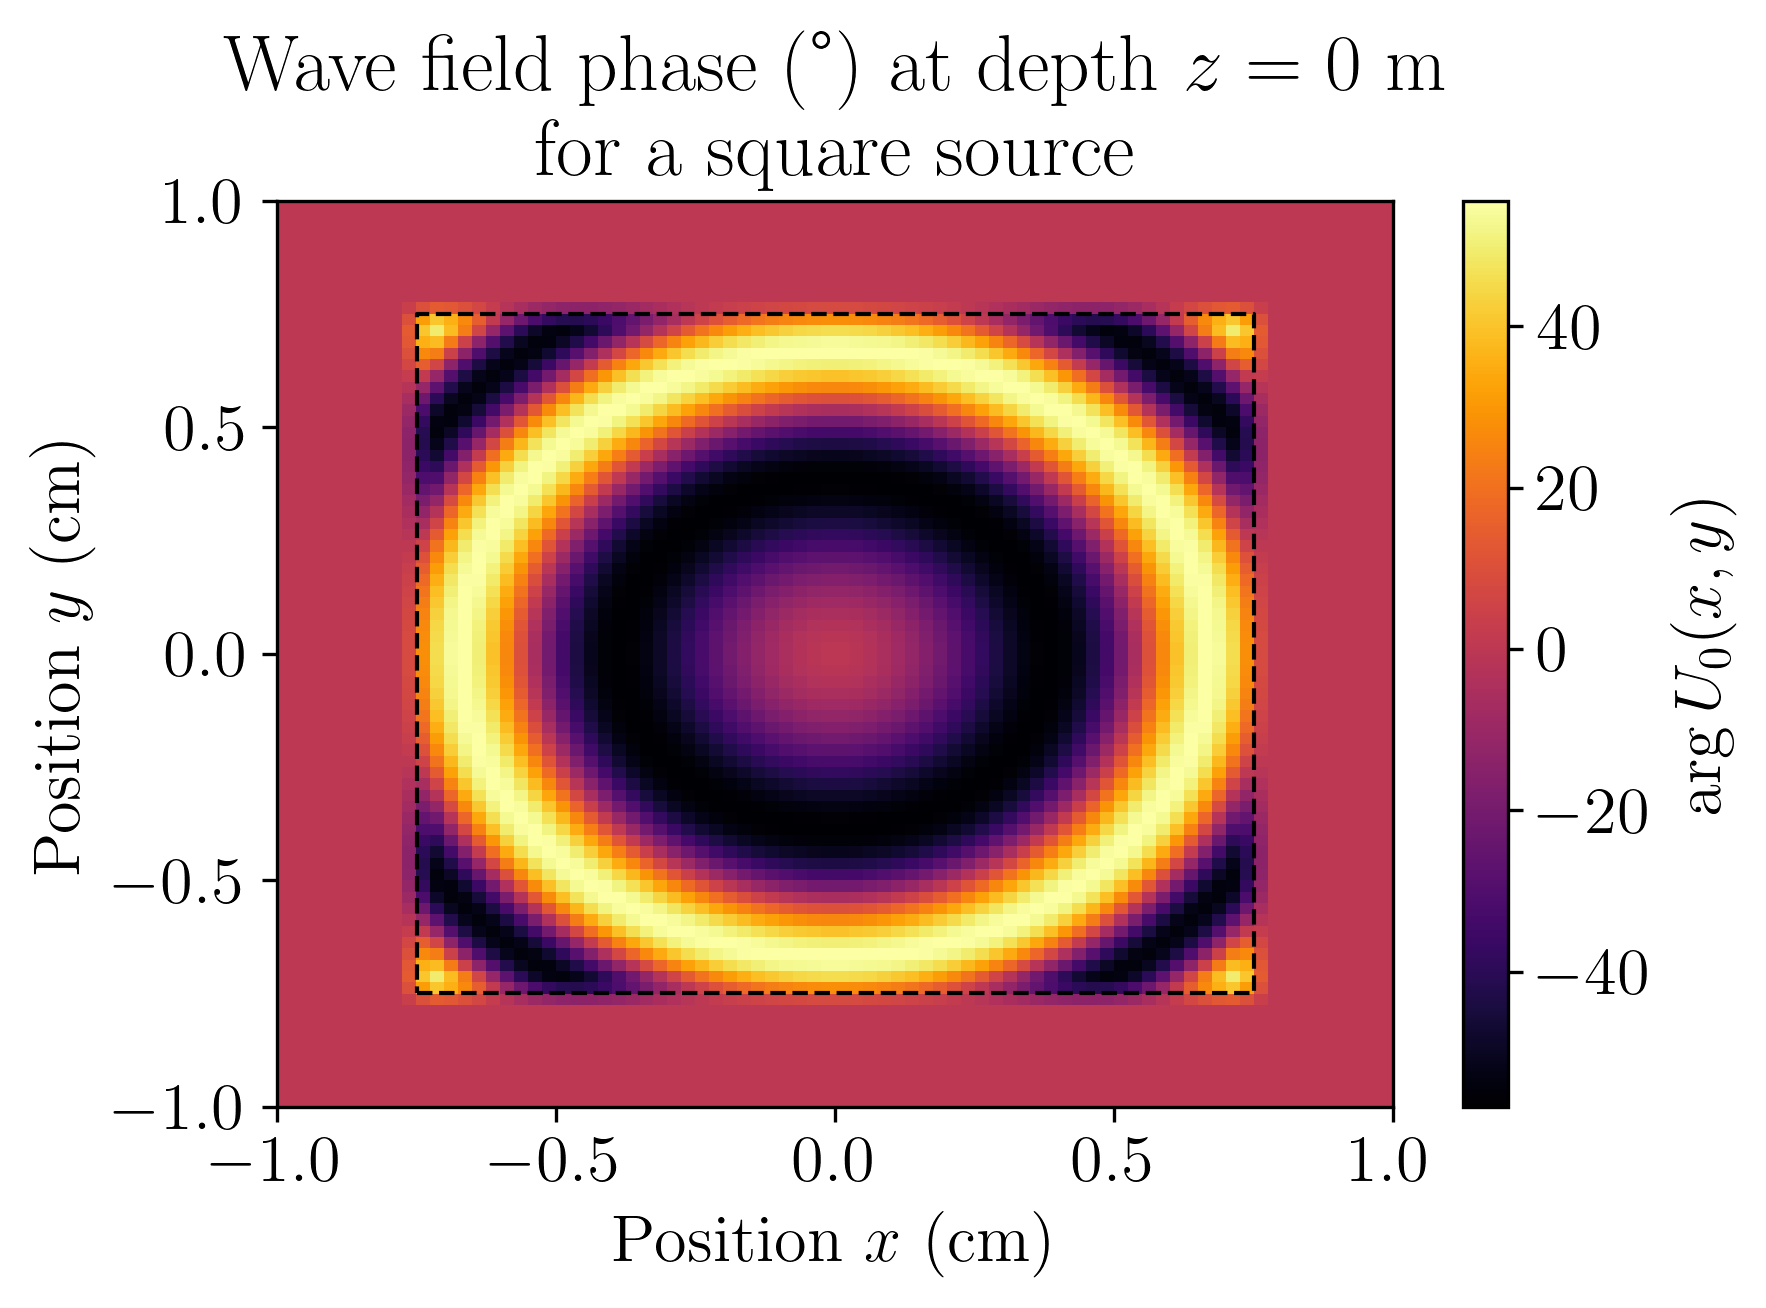

In [10]:
# Plot of the wave field phase in the aperture


plt.pcolormesh(config['ax']*1e2,config['ay']*1e2,np.imag(U_0_mod_delayed)*180/np.pi,cmap='inferno',shading='auto')
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.xlabel('Position $x$ (cm)')
plt.ylabel('Position $y$ (cm)')
plt.plot([-15*config['lambda']*100,15*config['lambda']*100,15*config['lambda']*100,-15*config['lambda']*100,-15*config['lambda']*100],[-15*config['lambda']*100,-15*config['lambda']*100,15*config['lambda']*100,15*config['lambda']*100,-15*config['lambda']*100],color='k',linestyle='--',linewidth=1)
plt.title('Wave field phase (°) at depth $z=0$ m \n for a square source')
c = plt.colorbar()
c.set_label('$\\arg U_0(x,y)$')
plt.savefig('images/ASA/square/wave_field_2D_z=0_square_smoothed_focuses.png',dpi=300)



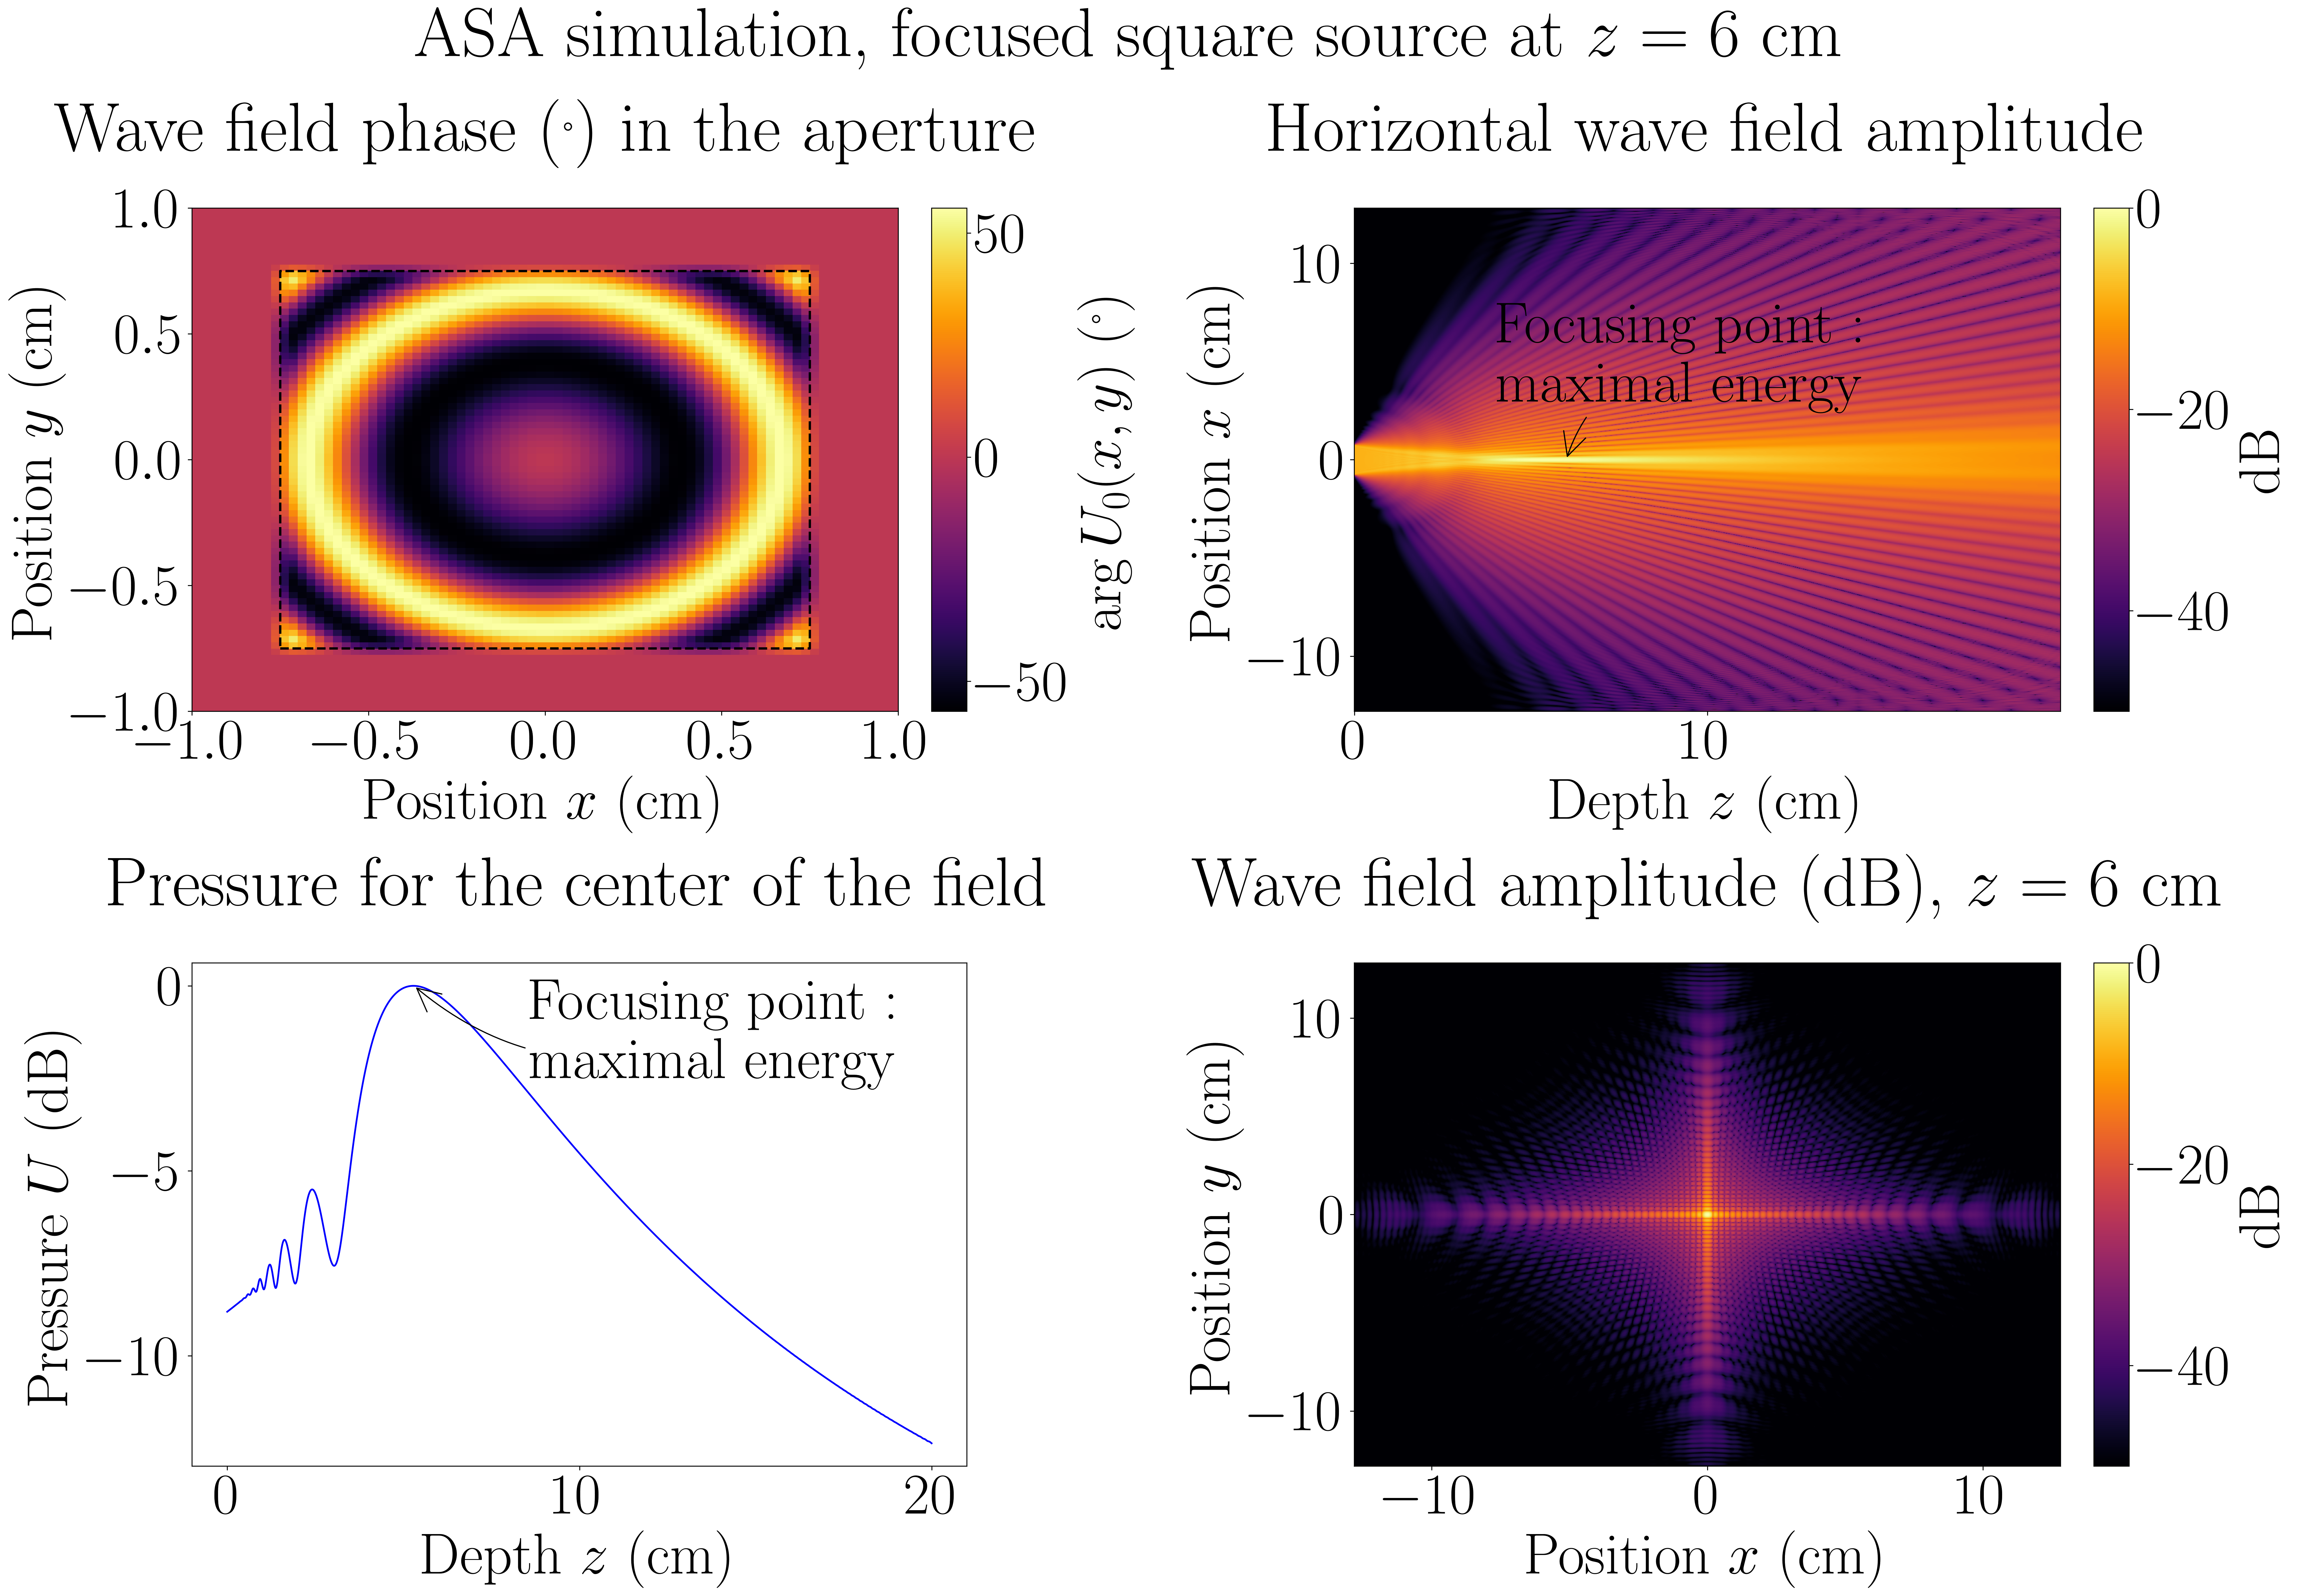

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams.update({'font.size': 50})

fig,axs = plt.subplots(2,2,figsize=(30,20))
ax1,ax2,ax3,ax4 = axs.flat



a = ax1.pcolormesh(config['ax']*1e2,config['ay']*1e2,np.imag(U_0_mod_delayed)*180/np.pi,cmap='inferno',shading='auto')
ax1.set_xlim([-1,1])
ax1.set_ylim([-1,1])
ax1.set_xlabel('Position $x$ (cm)')
ax1.set_ylabel('Position $y$ (cm)')
ax1.plot([-15*config['lambda']*100,15*config['lambda']*100,15*config['lambda']*100,-15*config['lambda']*100,-15*config['lambda']*100],[-15*config['lambda']*100,-15*config['lambda']*100,15*config['lambda']*100,15*config['lambda']*100,-15*config['lambda']*100],color='k',linestyle='--',linewidth=2)     
ax1.set_title('Wave field phase (°) in the aperture',y=1.1)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.4)
b = fig.colorbar(a, cax=cax, orientation='vertical');
b.set_label('$\\arg U_0(x,y)$ (°)')

# 2D image of the predicted wavefield for y=0m

a = ax2.pcolormesh(Z*1e2,config['ax']*1e2,10*np.log10(np.abs(W)/np.max(np.abs(W))),cmap='inferno',shading='auto',vmin=-50,vmax=0)
ax2.set_ylabel('Position $x$ (cm)')
ax2.set_xlabel('Depth $z$ (cm)')
ax2.set_title('Horizontal wave field amplitude',y=1.1)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.4)
b = fig.colorbar(a, cax=cax, orientation='vertical');
b.set_label('dB')

ax2.annotate('Focusing point :\n maximal energy',
         xy=(6, 0), xycoords='data',
         xytext=(-60, +50), textcoords='offset points',
         arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=+.3"))


####


ax3.plot(Z*1e2,10*np.log10(np.abs(W[config['Nx']//2,:])/np.max(np.abs(W[config['Nx']//2,:]))),color='blue',linewidth=1.5)
ax3.set_xlabel('Depth $z$ (cm)')
ax3.set_ylabel('Pressure $U$ (dB)')
ax3.set_title('Pressure for the center of the field',y=1.1)
ax3.annotate('Focusing point :\n maximal energy',
         xy=(5.3, 0), xycoords='data',
         xytext=(100, -80), textcoords='offset points',
         arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-.3"))




###

a = ax4.pcolormesh(config['ax']*1e2,config['ay']*1e2,10*np.log10(np.abs(U_mod_delayed)/np.max(np.abs(U_mod_delayed))),cmap='inferno',shading='auto',vmin=-50,vmax=0)
ax4.set_xlabel('Position $x$ (cm)')
ax4.set_ylabel('Position $y$ (cm)')
#ax4.set_xlim([-2,2])
#ax4.set_ylim([-2,2])
ax4.set_title('Wave field amplitude (dB), $z=6$ cm',y=1.1)
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.4)
b = fig.colorbar(a, cax=cax, orientation='vertical');
b.set_label('dB')

fig.subplots_adjust(wspace=0.5)
fig.subplots_adjust(hspace=0.5)

fig.suptitle('ASA simulation, focused square source at $z=6$ cm',y=1)
plt.savefig('images/ASA/square/all_smoothed_focused.png',dpi=300)

In [16]:
plt.plot(config['ax']*1e2,20*np.log10(np.abs(U_mod_delayed[:,511])/np.max(np.abs(U_mod_delayed[:,511]))),color='red',linewidth=1)
plt.xlabel('Position $x$ (cm)')
plt.ylabel('Amplitude $U$ (dB)')
plt.title('Wave field amplitude (dB) at depth $z=6$ cm and \n $y=0$ cm for a square source, estimated using ASA')
plt.savefig('images/ASA/square/wave_field_1D_z=6cm_square_focused.png')